In [32]:
from datetime import date


import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
def dateExtractor(data, column_name, lower_limit, upper_limit):

    #5-7 for month
    #10-12 for hour
    data[column_name] = data['JOBCREATEDATE'].apply(lambda x: x[lower_limit:upper_limit])
    data[column_name] = data[column_name].astype(int)
    scaler = MinMaxScaler()
    data[[column_name]] = scaler.fit_transform(data[[column_name]])
    return data


def yearExtractor(data):
    
    data['year'] = data['JOBCREATEDATE'].apply(lambda x: x[0:4])
    #data['year'] = data['year'].astype(int)
    tempDataFrame = pd.get_dummies(data['year'])
    data = pd.concat([data,tempDataFrame], axis=1) 
    return data


def dateDifference(data):
    
    data['JOBCREATEDATE'] = pd.to_datetime(data['JOBCREATEDATE'])
    data['JOBDATE'] = pd.to_datetime(data['JOBDATE'], errors = 'coerce')
    data['diff'] = data['JOBDATE'] - data['JOBCREATEDATE']
    data['diff'] = data['diff'].fillna(pd.Timedelta(seconds=0))
    data['diff']= data['diff'].dt.days.astype(int)
    return data


def normalizeOtherFeatures(data):
    
#     data['USERID'] = data['USERID'].apply(lambda x: x[8:-1])
    data['LOCATION'] = data['LOCATION'].apply(lambda x: x[5:-1])
#     data['USERID'] = data['USERID'].astype(int)
    data['LOCATION'] = data['LOCATION'].astype(int)
    scaler = MinMaxScaler()
    data[['USERID', 'LOCATION']] = scaler.fit_transform(data[['USERID', 'LOCATION']])
    return data


def dummySucess(data):
    
    tempDataFrame = pd.get_dummies(data['JOBSTATUS'])
    data = pd.concat([data,tempDataFrame], axis=1)
    return data


def removeExtraFeatures(data):
    
    removeList = ['JOBSTATUS', 'JOBCREATEDATE', 'JOBDATE', 'JOBSTATUS', 'year', 'JOBIDENTIFIER', 'SERVICENAME']
    data.drop(removeList, inplace=True, axis=1)
    return data

def dataPrep(data):

    data = dateExtractor(data, 'month', 5, 7)
    data = dateExtractor(data, 'hour', 10, 12)
    data = yearExtractor(data)
    data = dateDifference(data)
    data = normalizeOtherFeatures(data)
    data = dummySucess(data)
    data = removeExtraFeatures(data)
    data = data.dropna(axis=0)
    
    return data

def drawElbow(data):
    wcss = []
    for k in range(1,11):
        kmeans = KMeans(n_clusters=k, init="k-means++")
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
    plt.figure(figsize=(12,6))    
    plt.grid()
    plt.plot(range(1,11),wcss, linewidth=2, color="red", marker ="8")
    plt.xlabel("K Value")
    plt.xticks(np.arange(1,11,1))
    plt.ylabel("WCSS")
    plt.show()

In [34]:
data = pd.read_csv("../input/customersegmentation/customersegmentationdata.csv")
data = dataPrep(data)
data.head(5)

,USERID,LOCATION,REVENUE,PRICE,TENURE,month,hour,2018,2019,2020,diff,NO SUCCESS,SUCCESS
0,1.511595e-07,0.372222,337,1156.0,0,0.181818,0.5,0,1,0,6,0,1
1,1.707385e-07,0.200000,8,20966.0,0,0.181818,1.0,0,1,0,184,1,0
2,1.619765e-07,0.161111,0,344.0,518,0.636364,0.5,0,0,1,0,1,0
3,2.683520e-07,0.505556,15,2794.0,0,0.272727,0.5,0,1,0,184,1,0
4,1.597791e-07,0.388889,36,1254.0,176,0.636364,0.5,0,1,0,0,1,0


In [35]:
data['USERID'].values

array([1.51159504e-07, 1.70738509e-07, 1.61976487e-07, ...,
       2.79904353e-07, 6.91520608e-08, 2.13855164e-08])

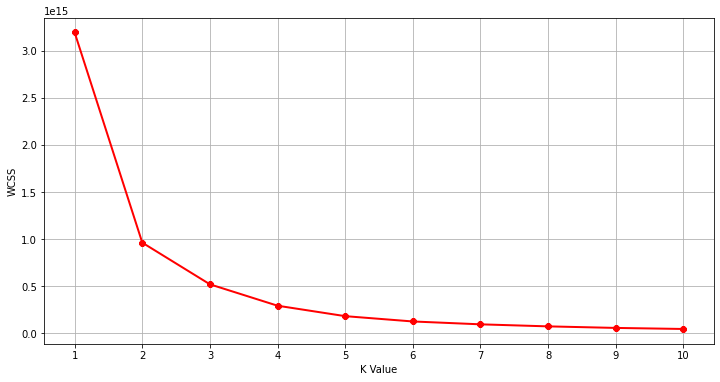

In [36]:
drawElbow(data)

In [37]:
km = KMeans(n_clusters=4)
clusters = km.fit_predict(data)
data["label"] = clusters

In [ ]:
val = int(input("Enter your value: "))
data = data.drop(['label'], axis=1)
if val in data['USERID'].values:
    km.predict(data[data['USERID']==val])
else:
    print("USERID not found!")

In [11]:
data['label'].value_counts()

2    323293
0      1266
3       546
1       124
Name: label, dtype: int64

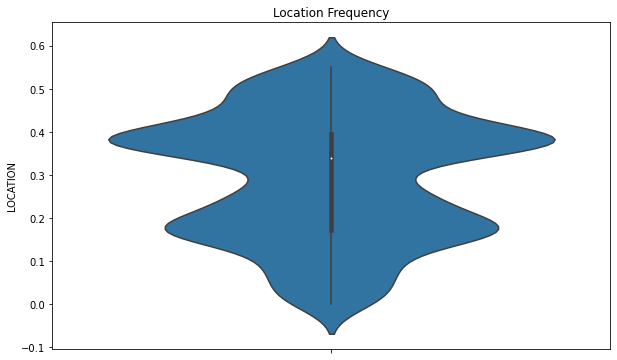

In [26]:
subData = data[data['label']==0]
plt.figure(figsize=(10,6))
plt.title("Location Frequency")
sns.axes_style("dark")
sns.violinplot(y=subData["LOCATION"])
plt.show()

In [27]:
subData['NO SUCCESS'].value_counts()

1    1263
0       3
Name: NO SUCCESS, dtype: int64

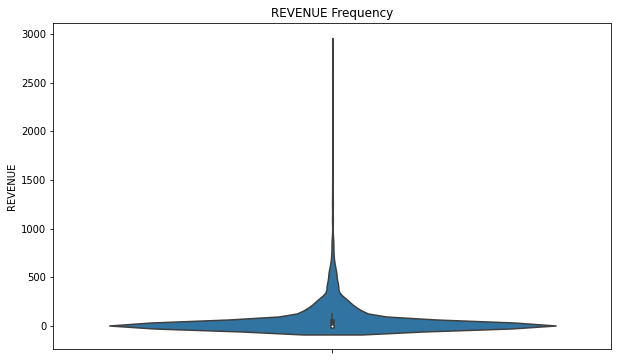

In [28]:
subData = data[data['label']==0]
plt.figure(figsize=(10,6))
plt.title("REVENUE Frequency")
sns.axes_style("dark")
sns.violinplot(y=subData["REVENUE"])
plt.show()

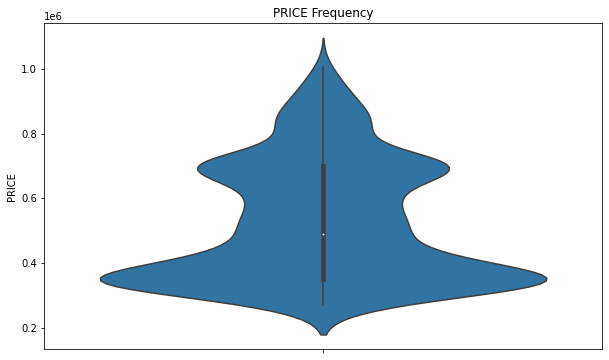

In [29]:
subData = data[data['label']==0]
plt.figure(figsize=(10,6))
plt.title("PRICE Frequency")
sns.axes_style("dark")
sns.violinplot(y=subData["PRICE"])
plt.show()

In [31]:
#All Unsucessful
subData['NO SUCCESS'].value_counts()

1    124
Name: NO SUCCESS, dtype: int64

In [34]:
for i in range(0,4):
    subData = data[data['label']==i]
    print("Total records: {}".format(len(subData)))
    print("No success records: {}\n**********".format(subData['NO SUCCESS'].value_counts()))
    

Total records: 323293
No success records: 1    294027
0     29266
Name: NO SUCCESS, dtype: int64
**********
Total records: 546
No success records: 1    546
Name: NO SUCCESS, dtype: int64
**********
Total records: 1266
No success records: 1    1263
0       3
Name: NO SUCCESS, dtype: int64
**********
Total records: 124
No success records: 1    124
Name: NO SUCCESS, dtype: int64
**********


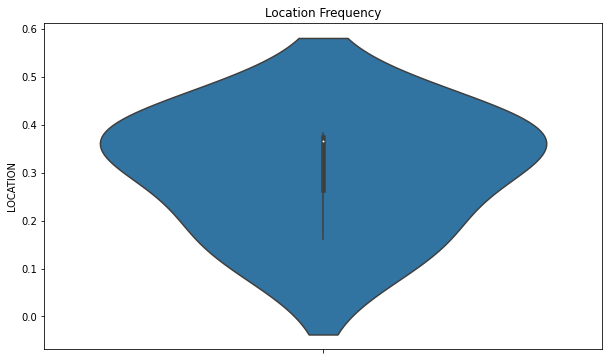

In [47]:
subData = data[data['label']==2]
subData = subData[subData['SUCCESS']==1]
plt.figure(figsize=(10,6))
plt.title("Location Frequency")
sns.axes_style("dark")
sns.violinplot(y=subData["LOCATION"])
plt.show()

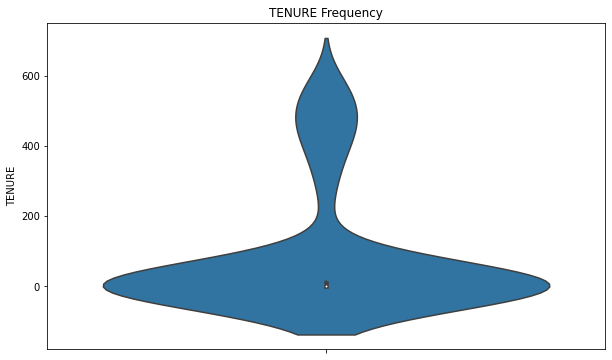

In [29]:
# zero tenure
plt.figure(figsize=(10,6))
plt.title("TENURE Frequency")
sns.axes_style("dark")
sns.violinplot(y=subData["TENURE"])
plt.show()

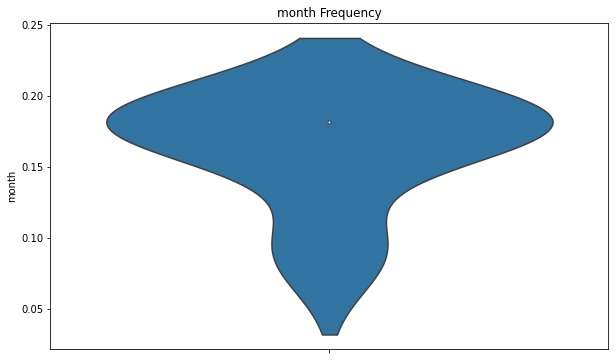

In [13]:
#tendency is higher in some months
plt.figure(figsize=(10,6))
plt.title("month Frequency")
sns.axes_style("dark")
sns.violinplot(y=subData["month"])
plt.show()

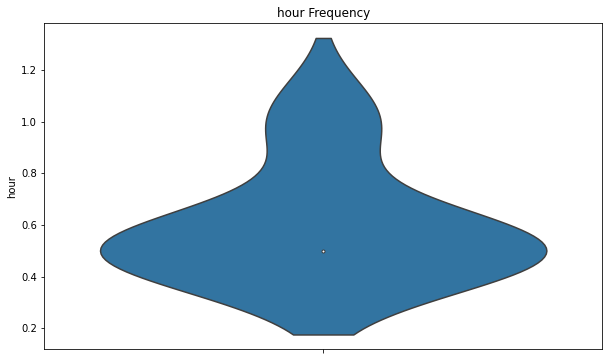

In [14]:
#In the morning, more submissions are registered
plt.figure(figsize=(10,6))
plt.title("hour Frequency")
sns.axes_style("dark")
sns.violinplot(y=subData["hour"])
plt.show()

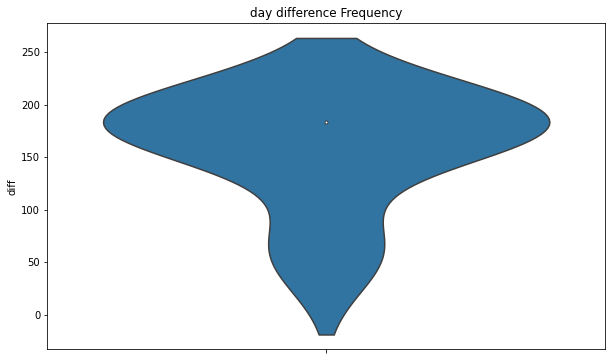

In [15]:
#There are long differences in terms of days, between the jobcreate and the job assigned date.
plt.figure(figsize=(10,6))
plt.title("day difference Frequency")
sns.axes_style("dark")
sns.violinplot(y=subData["diff"])
plt.show()

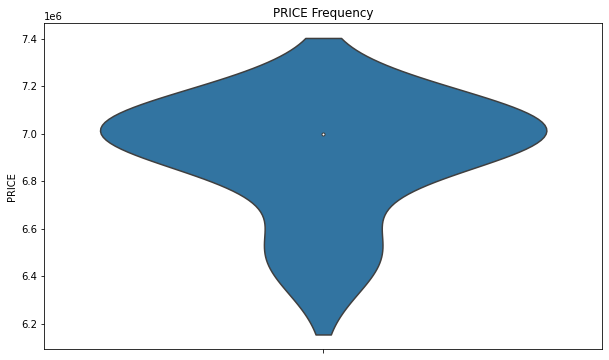

In [16]:

#There are long differences in terms of days, between the jobcreate and the job assigned date.
plt.figure(figsize=(10,6))
plt.title("PRICE Frequency")
sns.axes_style("dark")
sns.violinplot(y=subData["PRICE"])
plt.show()

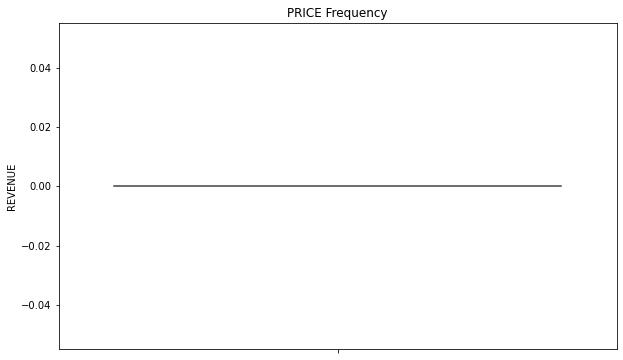

In [17]:

#There are long differences in terms of days, between the jobcreate and the job assigned date.
plt.figure(figsize=(10,6))
plt.title("PRICE Frequency")
sns.axes_style("dark")
sns.violinplot(y=subData["REVENUE"])
plt.show()

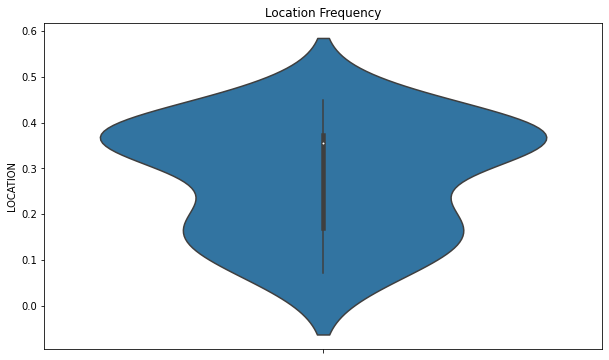

In [18]:
subData = data[data['label']==1]
plt.figure(figsize=(10,6))
plt.title("Location Frequency")
sns.axes_style("dark")
sns.violinplot(y=subData["LOCATION"])
plt.show()

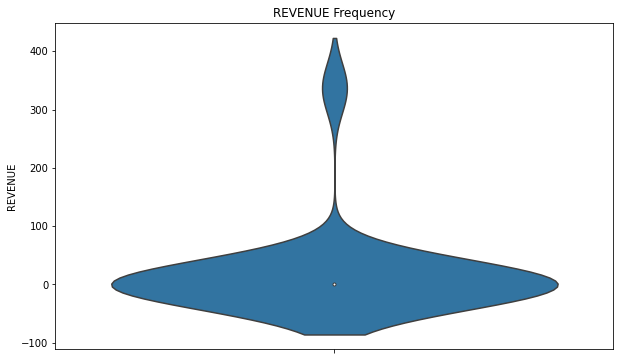

In [21]:

#There are long differences in terms of days, between the jobcreate and the job assigned date.
plt.figure(figsize=(10,6))
plt.title("REVENUE Frequency")
sns.axes_style("dark")
sns.violinplot(y=subData["REVENUE"])
plt.show()